In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
# from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,low_normal,0.0,1.0,1.0,0.0,-606.0,179055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,0.000,0.000000,0.0,0.0,0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,low_normal,1.0,1.0,1.0,-135882.0,-828.0,348637.5,-746.0,1035882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-536.0,0.000,0.000000,0.0,0.0,0.0,-23.0,0.0,0.0,-66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,middle,0.0,1.0,1.0,4176.0,-815.0,20106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-724.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,0.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,XNA,0.0,1.0,1.0,0.0,-311.0,267930.0,-181.0,675000.0,-181.0,270000.0,-1.0,0.0,-2.0,0.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.0,-11.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,0.0,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,middle,1.0,1.0,1.0,-26788.5,-1768.0,30663.0,-374.0,274288.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,29857.365,452.384318,0.0,16.0,0.0,-3.0,0.0,0.0,-9.0,0.0,0.0,-10.0,0.0,0.0,-35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,22

In [5]:
train = train[:35000]

In [6]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_DOWN_PAYMENT,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
SK_ID_CURR,1.000000,0.009219,0.000084,-0.002476,-0.005643,-0.001722,-0.006095,-0.002981,-0.005179,0.008276,0.000563,-0.005236,0.005802,0.000924,-0.008289,-0.005720,-0.004280,-0.006074,-0.003590,-0.001828,0.003688,0.004736,-0.006329,-0.010567,-0.005857,-0.001278,-0.001745,-0.003466,-0.001356,-0.006227,-0.004136,0.001811,-0.001939,-0.005130,-0.003627,-0.004783,0.000983,0.000106,-0.007186,-0.004553,...,0.004949,0.006899,-0.003621,-0.008121,-0.002461,0.004114,0.001721,-0.000442,-0.002710,-0.000789,0.004460,-0.003673,0.001518,-0.004314,-0.006385,0.001285,-0.002229,-0.001807,-0.002595,-0.001113,0.006710,0.003655,-0.000356,0.009059,0.011144,-0.000798,0.004207,0.010322,0.000524,-0.007884,0.003645,-0.004499,-0.009234,-0.005831,0.001531,-0.009294,0.008884,0.003684,-0.009553,0.000141
TARGET,0.009219,1.000000,0.026970,0.013968,-0.031771,-0.009556,-0.039491,-0.039429,0.076970,-0.038405,0.045494,0.045246,0.002923,0.001584,0.039537,0.021128,0.006930,-0.034539,0.002751,0.010437,0.065829,0.066655,-0.030448,0.012988,0.002096,-0.004991,0.034484,0.042460,0.026921,-0.064689,-0.154004,-0.121534,-0.033586,-0.029550,-0.043162,-0.034208,-0.013438,-0.033139,-0.034202,-0.047125,...,-0.021344,-0.005696,0.016143,0.018513,-0.006298,0.012727,-0.025186,0.011984,-0.014078,0.004129,0.007412,-0.005462,0.015650,-0.008877,0.011640,-0.009165,0.003290,-0.001376,0.012229,0.018010,0.033868,0.013348,-0.009344,0.021988,0.027164,0.014321,0.034573,0.040958,0.002435,0.002872,0.033048,0.019473,0.002380,0.029316,0.025148,-0.000318,0.011296,0.019650,-0.000889,0.005267
CNT_CHILDREN,0.000084,0.026970,1.000000,0.009199,0.006437,0.027096,0.001218,-0.023077,0.329268,-0.238018,0.182531,-0.029994,0.074750,0.003074,0.239036,0.055924,0.000216,-0.030644,0.026995,0.880790,0.021041,0.019069,-0.009517,-0.012666,0.009080,0.018570,0.021799,0.070771,0.067480,0.043380,-0.020276,-0.010577,-0.035494,-0.025169,-0.031017,-0.019978,-0.012648,-0.030600,-0.029632,-0.033213,...,0.012363,-0.034055,0.016737,0.028847,0.028600,0.026294,0.005264,0.037675,-0.054019,0.009026,-0.003117,0.002813,-0.009772,0.006886,0.000739,0.013692,0.000947,0.015303,-0.002137,0.000819,0.007541,-0.009218,-0.019354,0.014751,0.010855,0.006599,0.006774,0.008449,-0.039982,0.011586,0.005210,-0.035157,0.012455,-0.000138,-0.024299,0.012936,0.019594,-0.009856,0.011424,0.005845
AMT_INCOME_TOTAL,-0.002476,0.013968,0.009199,1.000000,0.058158,0.069583,0.058415,0.023838,0.014910,-0.026964,0.006011,0.002672,0.005679,0.000385,0.026936,-0.009742,-0.002997,-0.003204,0.012563,0.010915,-0.032496,-0.034484,0.016358,0.011124,0.022861,0.021384,-0.000325,-0.001080,-0.000176,0.017897,0.013014,-0.0043

In [7]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_defaulted_mean',
 'AMT_defaulted3',
 'STATUS_0']

In [8]:
train = train.drop(to_drop, axis=1)

In [9]:
train['OCCUPATION_TYPE'].value_counts()/len(train) 
train['OCCUPATION_TYPE'].unique()
train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
        'Private service staff', 'Security staff','Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
train['ORGANIZATION_TYPE'].value_counts()/len(train) 
train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
       'Other','Electricity', 'Medicine',
       'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)


In [10]:
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.919257
1    0.080743
Name: TARGET, dtype: float64

In [11]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [12]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [13]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_2                  -0.154004
EXT_SOURCE_3                  -0.121534
EXT_SOURCE_1                  -0.064689
Days_employed_age             -0.058441
FLOORSMAX_AVG                 -0.047125
ratio_approved                -0.046823
YEARS_BEGINEXPLUATATION_AVG   -0.043162
REGION_POPULATION_RELATIVE    -0.039429
TOTALAREA_MODE                -0.037876
LIVINGAREA_AVG                -0.034994
Name: TARGET, dtype: float64

In [14]:
corr.tail(10)

FLAG_DOCUMENT_3                0.049296
DAYS_CREDIT1                   0.053723
DAYS_LAST_PHONE_CHANGE         0.059003
REGION_RATING_CLIENT           0.065829
REGION_RATING_CLIENT_W_CITY    0.066655
DAYS_EMPLOYED                  0.072260
DAYS_BIRTH                     0.076970
ratio_refused                  0.092140
TARGET                         1.000000
FLAG_DOCUMENT_12                    NaN
Name: TARGET, dtype: float64

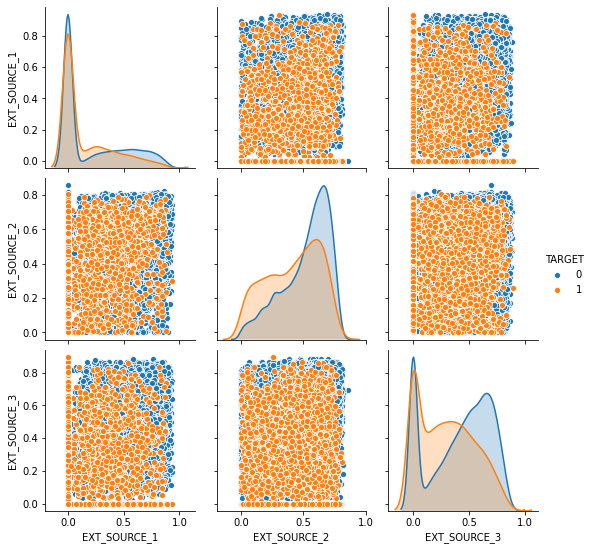

In [15]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

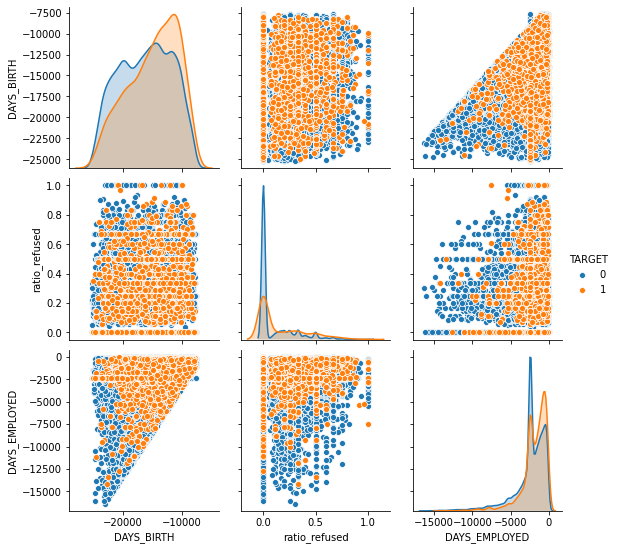

In [16]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [17]:
# # Polynomial Features
# poly_transformer = PolynomialFeatures(degree = 3)
# pfeatures = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused']] 
# poly_features = poly_transformer.fit_transform(pfeatures)
# names = poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused'])
# poly_features = pd.DataFrame(poly_features, columns = names)
# poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
# train = train.merge(poly_features, on='SK_ID_CURR', how= 'left')
# train

In [18]:
train = pd.get_dummies(train, drop_first=True)

In [19]:
train['TARGET'].value_counts() # balance: round(27597/2) = 13798

0    32174
1     2826
Name: TARGET, dtype: int64

In [20]:
# undersampling majority class to 50%

In [21]:
negative = train.loc[train['TARGET'] == 0]
positive = train.loc[train['TARGET'] == 1]
nclusters = 13798
nclusters

13798

In [22]:
# tsne = TSNE()
# rtrain = tsne.fit_transform(X)
# sns.scatterplot(rtrain[:,0], rtrain[:,1], hue=y, legend='full')

In [23]:
sc = StandardScaler()
transform = sc.fit_transform(negative)
negative = pd.DataFrame(transform, columns = negative.columns)
del transform

In [24]:
ac = AgglomerativeClustering(n_clusters = nclusters, affinity= 'euclidean', linkage= 'ward') 
clustering = ac.fit(negative)
negative['cluster'] = clustering.labels_
negative

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Missing,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_y_Consumer loans,NAME_CONTRACT_TYPE_y_Missing,NAME_CONTRACT_TYPE_y_Revolving loans,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,cluster
0,-1.734011,0.0,-0.573011,1.015313,1.699109,0.575644,-1.250494,-0.144613,0.582803,1.080868,1.803511,-0.458823,0.005575,0.477657,-0.495148,0.047359,1.593457,-0.240486,-0.170926,-2.054278,-2.038502,-0.337334,-0.124617,-0.228536,-0.20222,-0.291513,-0.542649,-0.462971,0.299984,0.535483,-1.566312,0.384759,0.216264,0.975366,1.496916,0.972651,0.423861,-0.397906,1.150649,1.809281,...,2.236652,-0.352836,-0.233537,-0.440877,-0.460891,-0.447647,-0.524766,-0.186904,1.205652,-0.374749,-0.477559,-0.139365,-0.138202,1.774036,-0.204375,1.010059,-0.069351,-0.067749,-1.007362,-0.083354,-0.079486,-0.074587,-0.525537,-0.520428,-0.132729,0.950262,-0.081828,-0.567659,-0.237652,-0.335034,-0.135966,-1.044828,-0.243866,-0.344256,-0.344256,-0.463318,-0.304131,1.666354,-0.673011,11988
1,-1.733926,0.0,-0.573011,-1.018264,-1.150475,-1.375657,-0.783465,-0.667638,1.028834,0.212485,0.317526,2.456694,0.005575,0.477657,2.019596,0.047359,1.593457,-0.240486,-1.277883,-0.079662,-0.040063,-0.955338,-0.124617,-0.228536,-0.20222,-0.291513,-0.542649,-0.462971,-0.775973,0.181782,1.151119,-0.609873,-0.534872,-1.033406,-0.703776,-0.279540,-0.372287,-0.730472,-0.751649,-0.531084,...,2.236652,-0.352836,-0.233537,-0.440877,-0.460891,-0.447647,-0.524766,5.350341,-0.829427,-0.374749,-0.477559,-0.139365,-0.138202,-0.563686,-0.204375,-0.990042,-0.069351,-0.067749,0.992692,-0.083354,-0.079486,-0.074587,-0.525537,-0.520428,-0.132729,-1.052341,-0.081828,-0.567659,-0.237652,-0.335034,-0.135966,0.957095,-0.243866,-0.344256,-0.344256,-0.463318,-0.304131,-0.600113,1.485859,420
2,-1.733755,0.0,-0.573011,-0.340405,-0.713427,0.170400,-0.928301,-0.658237,-0.274521,-1.361847,0.379885,-0.458823,0.005575,0.477657,-0.495148,0.047359,-0.627566,-0.240486,-0.170926,-0.079662,-0.040063,1.516677,-0.124617,-0.228536,-0.20222,-0.291513,-0.542649,-0.462971,-0.775973,0.685828,-1.566312,-0.609873,-0.534872,-1.033406,-0.703776,-0.279540,-0.372287,-0.730472,-0.751649,-0.531084,...,-0.447097,-0.352836,-0.233537,-0.440877,-0.460891,2.233902,1.905611,-0.186904,-0.829427,-0.374749,-0.477559,-0.139365,-0.138202,-0.563686,-0.204375,-0.990042,-0.069351,-0.067749,0.992692

In [25]:
def sampling(group):
    return group.sample(1, random_state=1)
negative = negative.groupby('cluster', as_index= False ).apply(sampling)
negative = negative.droplevel(level=1)
negative = negative.drop('cluster', axis=1)
negative = pd.DataFrame(sc.inverse_transform(negative), columns = negative.columns)
negative

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Missing,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_y_Consumer loans,NAME_CONTRACT_TYPE_y_Missing,NAME_CONTRACT_TYPE_y_Revolving loans,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,122025.0,0.0,0.0,112500.0,270000.0,13500.0,0.024610,-8866.0,-1797.0,-8866.0,-1524.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,15.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.453012,0.660049,0.457900,0.1227,0.1101,0.9806,0.7348,5.060000e-02,0.00,0.2759,1.667000e-01,0.2083,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-8.673617e-19,0.0,0.0,1.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,120639.0,0.0,0.0,99000.0,405000.0,12717.0,0.008625,-17061.0,-8738.0,-9243.0,-601.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,12.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.703148,0.283231,0.497469,0.1433,0.0818,0.9846,0.7892,8.950000e-02,0.16,0.1379,3.333000e-01,0.3750,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-8.673617e-19,0.0,0.0,1.000000e+00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130117.0,0.0,1.0,218700.0,1515415.5,41800.5,0.030755,-14990.0,-1776.0,-7372.0,-1452.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.680249,0.761483,0.676993,0.0000,0.0000,0.0000,0.0000,-1.734723e-18,0.00,0.0000,-1.387779e-17,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,2.775558e-17,0.0,0.0,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,-2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,100749.0,0.0,0.0,171000.0,679500.0,19998.0,0.019689,-17016.0,-261.0,-1127.0,-543.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.736510,0.679545,0.282248,0.0000,0.0000,0.0000,0.0000,-1.734723e-18,0.00,0.0000,-1.387779e-17,0.0000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-3.469447e-18,2.775558e-17,0.0,0.0,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,-2.775558e-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,121865.0,0.0,2.0,382500.0,640080.0,29970.0,0.005144,-14380.0,-1069.0,-1726.0,-4967.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.000000e+00,1.0,0.421077,0.595913,0.424130,0.0000,0.0000,0.9851,0.0000,-1.734723e-18,

In [26]:
train = pd.concat([negative, positive], axis=0, sort= False)
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
train = train.sample(frac=1)
train = train.reset_index(drop= True)
train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Others,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Missing,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Missing,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_y_Consumer loans,NAME_CONTRACT_TYPE_y_Missing,NAME_CONTRACT_TYPE_y_Revolving loans,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,123870,0.0,0.0,225000.0,983299.5,41791.5,0.009657,-20322.0,-1610.0,-9716.0,-2818.0,12.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,14.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.000000,0.714444,0.000000,0.1113,0.0715,0.9861,0.8096,4.650000e-02,0.120,0.1034,3.333000e-01,0.3750,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,1.000000e+00,0.0,1.0,0.0,0.0,0.0,-8.673617e-19,0.0,0.0,1.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,104477,0.0,2.0,270000.0,945000.0,40167.0,0.015221,-16792.0,-784.0,-7643.0,-337.0,22.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,10.0,0.0,1.0,1.0,1.0,1.000000e+00,1.0,0.000000,0.550632,0.517297,0.0000,0.0000,0.0000,0.0000,-1.734723e-18,0.000,0.0000,-1.387779e-17,0.0000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,2.775558e-17,0.0,0.0,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,-2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,133156,0.0,0.0,292500.0,1096020.0,48406.5,0.035792,-18309.0,-11332.0,-843.0,-1843.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.000000,0.124769,0.591977,0.0000,0.0000,0.0000,0.0000,-1.734723e-18,0.000,0.0000,-1.387779e-17,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,2.775558e-17,0.0,0.0,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,-2.775558e-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,134694,0.0,0.0,180000.0,610335.0,22050.0,0.016612,-15719.0,-1292.0,-4112.0,-4637.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.000000,0.622153,0.481249,0.0000,0.0000,0.0000,0.0000,-1.734723e-18,0.000,0.0000,-1.387779e-17,0.0000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.469447e-18,2.775558e-17,0.0,0.0,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,-2.775558e-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,105251,0.0,1.0,225000.0,508495.5,24592.5,0.007274,-10920.0,-2284.0,-3247.0,-3017.0,21.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,18.0,0.0,0.0,0.0,0.0,1.000000e+00,1.0,0.281070,0.398040,0.739412,0.0000,0.0000,0.0000,0.0000,-1.734723e-

In [27]:
train['TARGET'].value_counts()

0.0    13798
1.0     2826
Name: TARGET, dtype: int64

In [28]:
# SMOTE oversampling of minority class

In [29]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [30]:
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
(y==0).sum()

13798

In [32]:
(y==1).sum()

13798

In [33]:
sc = StandardScaler()
X_pca = sc.fit_transform(X)
pca = PCA(n_components = 175)
X_pca = pca.fit_transform(X_pca)
sum(pca.explained_variance_ratio_)

0.9496458981350817

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
pipeline = make_pipeline(StandardScaler(), PCA(n_components = 175),  XGBClassifier())
params = {
    'xgbclassifier__learning_rate': [0.1], #[0.05, 0.1, 0.15, 0.2]
    'xgbclassifier__max_depth': [3], # [3, 4, 5, 6, 8, 10 ]
    'xgbclassifier__min_child_weight': [1], # [1, 3, 5, 7] "stop trying to split once your sample size in a node goes below a given threshold".
    'xgbclassifier__gamma' : [0.1], #[0, 0.1, 0.2, 0.3, 0.4],   #minimum loss reduction required to make a split.
    'xgbclassifier__colsample_bytree': [0.5] #[ 0.5, 0.7, 1]            
}
model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
model.best_score_

0.7950714584666897

In [35]:
from sklearn.metrics import accuracy_score
pred_class = model.predict(X_test)
print( 'XGBoost accuracy:', accuracy_score(y_test, pred_class))

XGBoost accuracy: 0.8001811594202899


In [36]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [37]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
print( confusion_matrix(y_test, pred_class) )
cm = confusion_matrix(y_test, pred_class)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[2168  599]
 [ 504 2249]]
Precision: 0.7896769662921348
Recall 0.8169269887395568


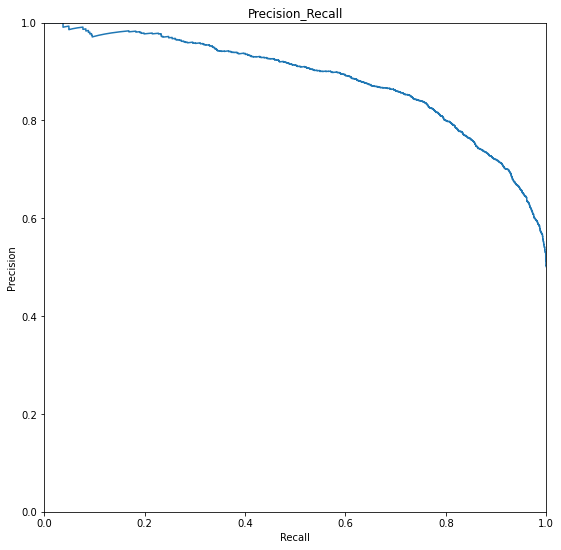

In [38]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [39]:
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
# pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


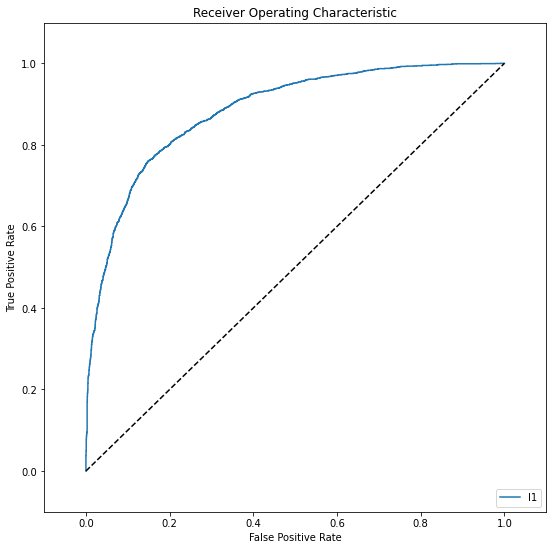

In [40]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
# AUROC
roc_auc_score(y_test, pred)

0.8833539808266464

In [42]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test, pred_class)
cohen_kappa

0.6003946330742